# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
from collections import Counter

def impurity(arr: np.array) -> float:
    p = np.array(list(Counter(arr).values())) / len(arr)
    return np.round(-np.sum(p * np.log(p)), decimals=2)

In [3]:
arr = np.array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0])
impurity(arr)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
def gini(arr: np.array) -> float:
    p = np.array(list(Counter(arr).values())) / len(arr)
    return np.sum(p * (1 - p))

In [5]:
arr_left = np.array([0, 0, 0, 0, 0, 0, 0, 0])
arr_right = np.array([1, 1])

gini(arr) - len(arr_left) / len(arr) * gini(arr_left) - len(arr_right) / len(arr) * gini(arr_right)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [6]:
reg_arr = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
np.mean(reg_arr)

40.6

Они будут равны среднему этих значений, то есть 40.6.

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [7]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [8]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:

    #находим пороги
    if feature_type == 'real':
        thresholds = (np.sort(np.unique(feature_vector))[:-1] + np.sort(np.unique(feature_vector))[1:]) / 2
    else:
        thresholds = np.sort(np.unique(feature_vector))
        
    def gini(arr: np.array) -> float:
        p = np.array(list(Counter(arr).values())) / len(arr)
        return np.sum(p * (1 - p))

    #считаем метрику для одного порога
    def Q(t):
        if feature_type == 'real':
            m = (feature_vector < t)
        else:
            m = (feature_vector == t)
        target_left = target_vector[m]
        target_right = target_vector[~m]
        if task == 'regression':
            H = np.var(target_vector)
            H_left = np.var(target_left)
            H_right = np.var(target_right)
        else:
            H = gini(target_vector)
            H_left = gini(target_left)
            H_right = gini(target_right)
        return H - len(target_left) / len(target_vector) * H_left - len(target_right) / len(target_vector) * H_right

    Q = np.vectorize(Q) #векторизуем
    criteria = Q(thresholds)
    criterion_best = np.max(criteria) #лучший критерий
    threshold_best = thresholds[np.argmax(criteria)] #лучший порог

    return thresholds, criteria, threshold_best, criterion_best
    
    
    

Эту функцию можно протестировать на датасете `California`.

In [9]:
from sklearn.datasets import fetch_california_housing

In [10]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [11]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [12]:
thresholds, criteria, threshold_best, criterion_best = find_best_split(X['MedInc'], y, 'regression', 'real')

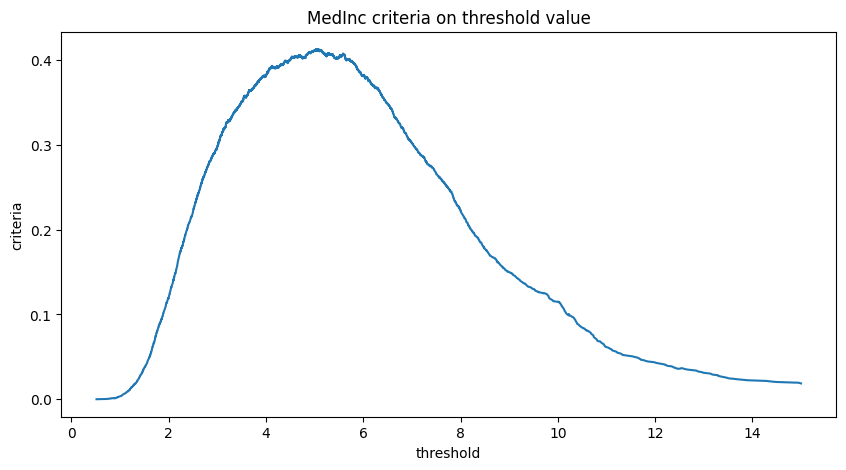

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(thresholds, criteria)
ax.set_title('MedInc criteria on threshold value')
ax.set_xlabel('threshold')
ax.set_ylabel('criteria')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [14]:
choose_criterion = pd.Series()
choose_threshold = pd.Series()
for column in X:
    
    thresholds, criteria, threshold_best, criterion_best = find_best_split(X[column], y, 'regression', 'real')
    choose_criterion[column] = criterion_best
    choose_threshold[column] = threshold_best

In [15]:
print('criterion')
print()
display(choose_criterion)
print()
print('threshold')
print()
display(choose_threshold)

criterion



MedInc        0.412751
HouseAge      0.030901
AveRooms      0.159208
AveBedrms     0.015253
Population    0.002831
AveOccup      0.073919
Latitude      0.090334
Longitude     0.050211
dtype: float64


threshold



MedInc           5.035150
HouseAge        51.500000
AveRooms         6.374305
AveBedrms        1.103378
Population    1160.500000
AveOccup         3.112543
Latitude        37.935000
Longitude     -121.865000
dtype: float64

Самый лучший предикат MedInc >= 5.035150, потому что самое большое качество.

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [16]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (feature_vector >= threshold_best)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (feature_vector == threshold_best)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node ["type"] = "terminal"
            node["class"] = Counter(sub_y[~numpy.isnan(sub_y)]).most_common(1)[0][0]
            return
        #добавил проверку на NaN, чтобы дерево не выдавало его в качестве прогноза
        #Я думаю, что больше никак пропущенные значения обрабатывать не нужно, ведь они просто разобьются по листам, а грамотный прогноз я обработал

        #добавляю критерий информативности разбиения узла в _feature_importance
        if feature_best in self._feature_importances.keys():
            self._feature_importances[feature_best].append(gini_best)
        else:
            self._feature_importances[feature_best] = [gini_best]

        node["type"] = "nonterminal"
        
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        else:
            if self._feature_types[node['feature_split']] == 'real':
                if x[node['feature_split']] < node['threshold']:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
            elif self._feature_types[node['feature_split']] == 'categorical':
                if x[node['feature_split']] == node['category_split']:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
            else:
                raise ValueError

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

    #считаю сумму для критериев информативности для каждого признака и возвращаю (почему бы нет)
    def get_feature_importances(self):
        importances = {}
        for feature, values in self._feature_importances.items():
            importances[feature] = np.sum(values)
        return importances

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [17]:
df = pd.read_csv('students.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


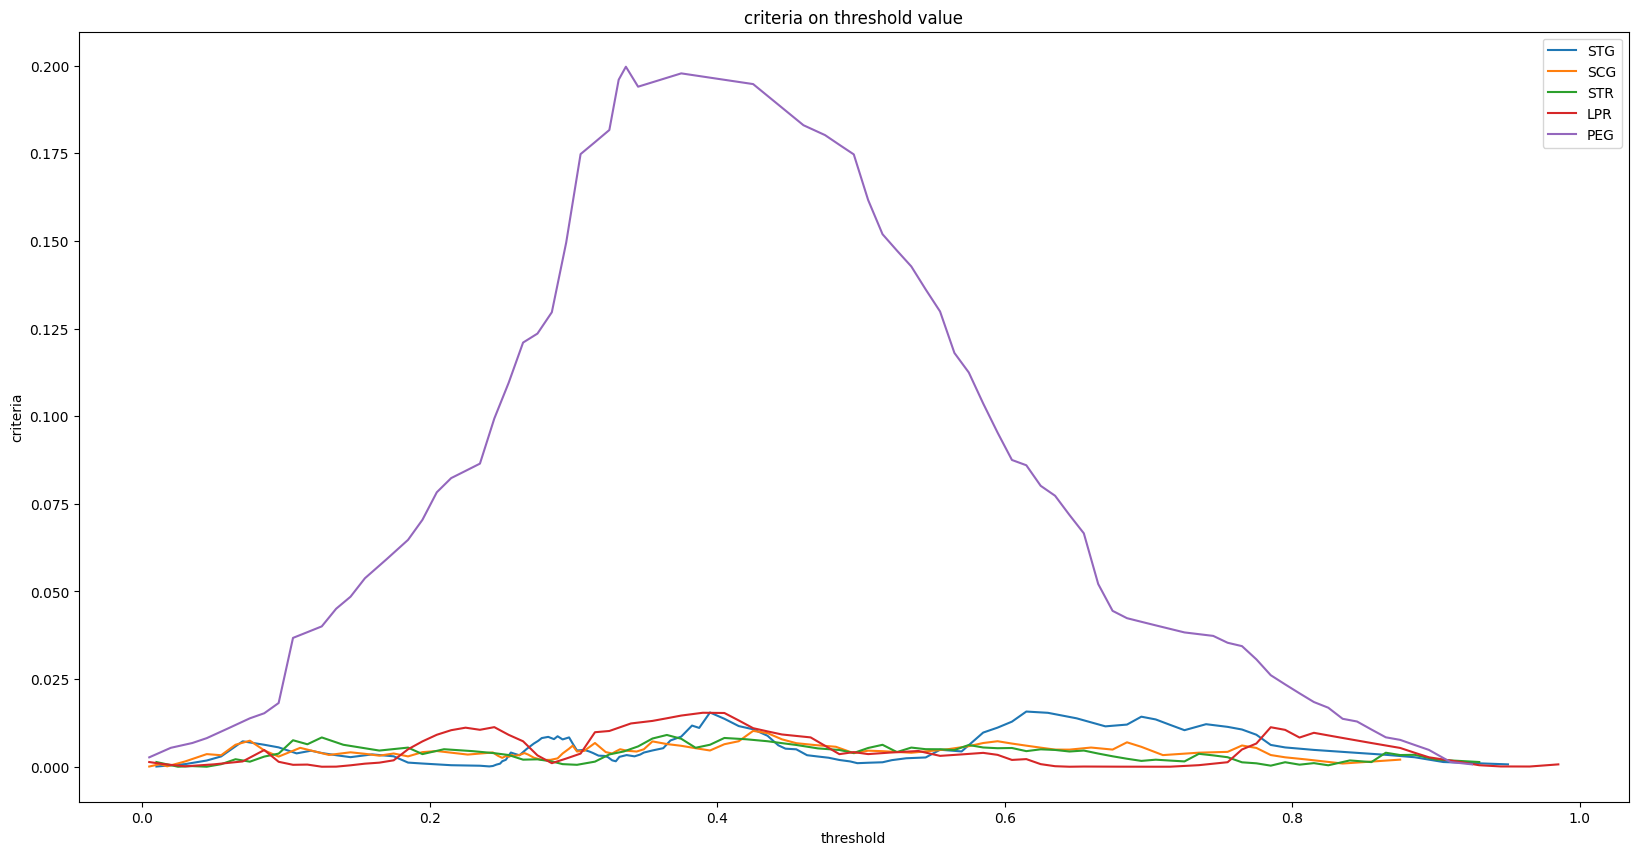

In [18]:
y = df['UNS']
X = df.drop(['UNS'], axis=1)

fig, ax = plt.subplots(figsize=(20, 10))

for column in X:
    thresholds, criteria, _, _ = find_best_split(X[column], y, task="regression",feature_type="real")
    ax.plot(thresholds, criteria, label=column)
    
ax.set_title('criteria on threshold value')
ax.set_xlabel('threshold')
ax.set_ylabel('criteria')
ax.legend()
plt.show()

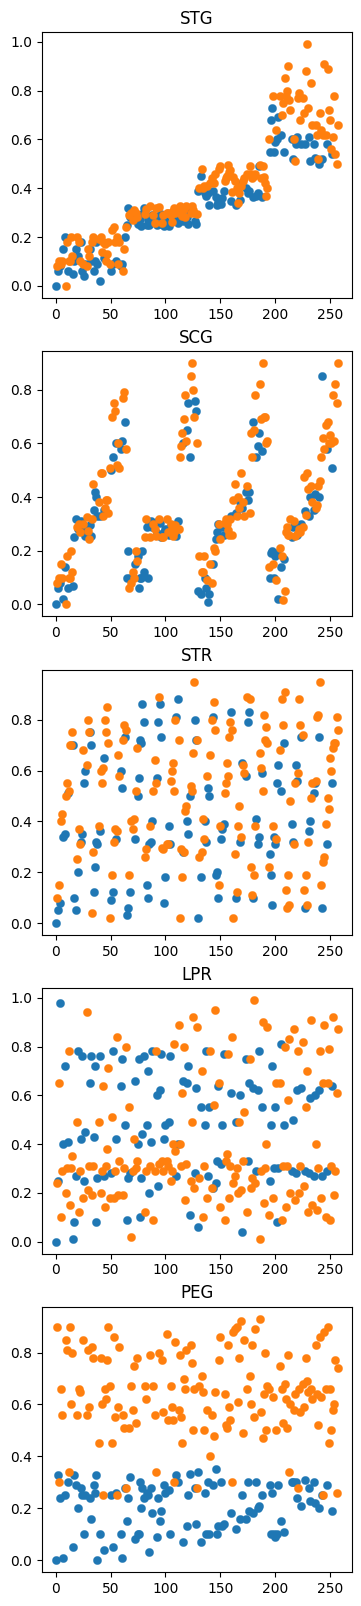

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

In [19]:
fig, axs = plt.subplots(5, 1, figsize=(4, 20))
for column, ax in zip(X, axs):
    fig = plt.figure(figsize=(5, 3))
    class_0 = X[column].where(y == 0).dropna()
    class_1 = X[column].where(y == 1).dropna()
    ax.scatter(class_0.index, class_0.values, label='Class 0', linewidths=0.2)
    ax.scatter(class_1.index, class_1.values, label='Class 1', linewidths=0.2)
    ax.set_title(column)
    
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [20]:
mushrooms = pd.read_csv('agaricus-lepiota.data')
mushrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

le = LabelEncoder()

for column in mushrooms:
    mushrooms[column] = le.fit_transform(mushrooms[column])
mushrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [22]:
y = mushrooms['p']
X = mushrooms.drop('p', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [23]:
clf = DecisionTree(['categorical'] * X_train.shape[1])
clf.fit(np.array(X_train), np.array(y_train))
y_pred = clf.predict(np.array(X_test))
print(y_pred)

[1 0 1 ... 0 1 0]


In [24]:
accuracy_score(y_pred, y_test)

1.0

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [25]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [26]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

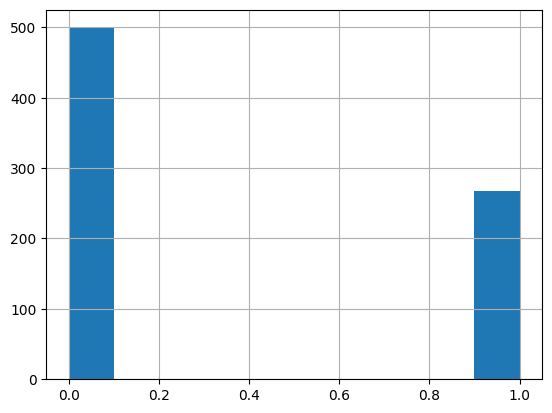

In [27]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [28]:
y = data['Outcome']
X = data.drop(columns=['Outcome'])
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [29]:
from sklearn.metrics import f1_score

depth = range(1, 16)
leaf = range(1, 11)
best = [0, 0, 0]

for d in depth:
    for l in leaf:
        dtc = DecisionTreeClassifier(max_depth=d, min_samples_leaf=l)
        dtc.fit(X_train, y_train)
        f1 = f1_score(dtc.predict(X_val), y_val)
        if f1 > best[2]:
            best = [d, l, f1]
        print(f'depth = {d}, leaves = {l}: f1 = {f1}')

depth = 1, leaves = 1: f1 = 0.5154639175257731
depth = 1, leaves = 2: f1 = 0.5154639175257731
depth = 1, leaves = 3: f1 = 0.5154639175257731
depth = 1, leaves = 4: f1 = 0.5154639175257731
depth = 1, leaves = 5: f1 = 0.5154639175257731
depth = 1, leaves = 6: f1 = 0.5154639175257731
depth = 1, leaves = 7: f1 = 0.5154639175257731
depth = 1, leaves = 8: f1 = 0.5154639175257731
depth = 1, leaves = 9: f1 = 0.5154639175257731
depth = 1, leaves = 10: f1 = 0.5154639175257731
depth = 2, leaves = 1: f1 = 0.5420560747663551
depth = 2, leaves = 2: f1 = 0.5420560747663551
depth = 2, leaves = 3: f1 = 0.5420560747663551
depth = 2, leaves = 4: f1 = 0.5420560747663551
depth = 2, leaves = 5: f1 = 0.5420560747663551
depth = 2, leaves = 6: f1 = 0.5420560747663551
depth = 2, leaves = 7: f1 = 0.5420560747663551
depth = 2, leaves = 8: f1 = 0.5420560747663551
depth = 2, leaves = 9: f1 = 0.5420560747663551
depth = 2, leaves = 10: f1 = 0.5420560747663551
depth = 3, leaves = 1: f1 = 0.5050505050505051
depth = 3, 

In [30]:
print(f'BEST depth = {best[0]}, leaves = {best[1]}: f1 = {best[2]}')

BEST depth = 5, leaves = 1: f1 = 0.5454545454545454


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

dtc = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1)
dtc.fit(X_train_full, y_train_full)

y_pred = dtc.predict(X_test)
print(f'acc = {accuracy_score(y_test, y_pred)}')
print(f'recall = {recall_score(y_test, y_pred)}')
print(f'precision = {precision_score(y_test, y_pred)}')
print(f'AUC-ROC score = {roc_auc_score(y_test, y_pred)}')

acc = 0.7619047619047619
recall = 0.4444444444444444
precision = 0.782608695652174
AUC-ROC score = 0.6888888888888889


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [32]:
clf = BaggingClassifier(n_estimators=50, random_state=42).fit(X_train_full, y_train_full)
y_pred = clf.predict(X_test)

print(f'acc = {accuracy_score(y_test, y_pred)}')
print(f'recall = {recall_score(y_test, y_pred)}')
print(f'precision = {precision_score(y_test, y_pred)}')
print(f'AUC-ROC score = {roc_auc_score(y_test, y_pred)}')

acc = 0.7532467532467533
recall = 0.5432098765432098
precision = 0.6875
AUC-ROC score = 0.7049382716049383


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [33]:
from sklearn.model_selection import cross_validate

depth = np.arange(1, 16)
leaves = np.arange(1, 11)
best = [0, 0, 0]

for d in depth:
    for l in leaves:
        dtc = RandomForestClassifier(n_estimators=50, max_depth=d, min_samples_leaf=l)
        f1 = cross_validate(dtc, X_train, y_train, scoring=['f1'])["test_f1"].mean()
        if f1 > best[2]:
            best = [d, l, f1]
        print(f'depth = {d}, leaves = {l}: f1 = {f1}')

depth = 1, leaves = 1: f1 = 0.3265074710236001
depth = 1, leaves = 2: f1 = 0.33214323567264736
depth = 1, leaves = 3: f1 = 0.38789703760291994
depth = 1, leaves = 4: f1 = 0.32731768569496766
depth = 1, leaves = 5: f1 = 0.41339139084869636
depth = 1, leaves = 6: f1 = 0.3863295553618135
depth = 1, leaves = 7: f1 = 0.27146106091339356
depth = 1, leaves = 8: f1 = 0.31271069657512107
depth = 1, leaves = 9: f1 = 0.30159172864548117
depth = 1, leaves = 10: f1 = 0.3501423149905123
depth = 2, leaves = 1: f1 = 0.5496209811999286
depth = 2, leaves = 2: f1 = 0.5370731707317072
depth = 2, leaves = 3: f1 = 0.5564481047407877
depth = 2, leaves = 4: f1 = 0.5504264840850207
depth = 2, leaves = 5: f1 = 0.5534654451386773
depth = 2, leaves = 6: f1 = 0.49606837606837606
depth = 2, leaves = 7: f1 = 0.5345090681676048
depth = 2, leaves = 8: f1 = 0.5484239668939791
depth = 2, leaves = 9: f1 = 0.5335950235950235
depth = 2, leaves = 10: f1 = 0.5401515899590353
depth = 3, leaves = 1: f1 = 0.5511807033546163
dep

In [34]:
print(f'BEST depth = {best[0]}, leaves = {best[1]}: f1 = {best[2]}')

BEST depth = 13, leaves = 3: f1 = 0.6677277613490238


In [35]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'acc = {accuracy_score(y_test, y_pred)}')
print(f'recall = {recall_score(y_test, y_pred)}')
print(f'precision = {precision_score(y_test, y_pred)}')
print(f'AUC-ROC score = {roc_auc_score(y_test, y_pred)}')

acc = 0.7445887445887446
recall = 0.5308641975308642
precision = 0.671875
AUC-ROC score = 0.6954320987654321


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [36]:
y_axis = []

for n in range(10, 400):
    clf = RandomForestClassifier(n_estimators=n).fit(X_train_full, y_train_full)
    y_axis.append(roc_auc_score(y_test, clf.predict(X_test)))

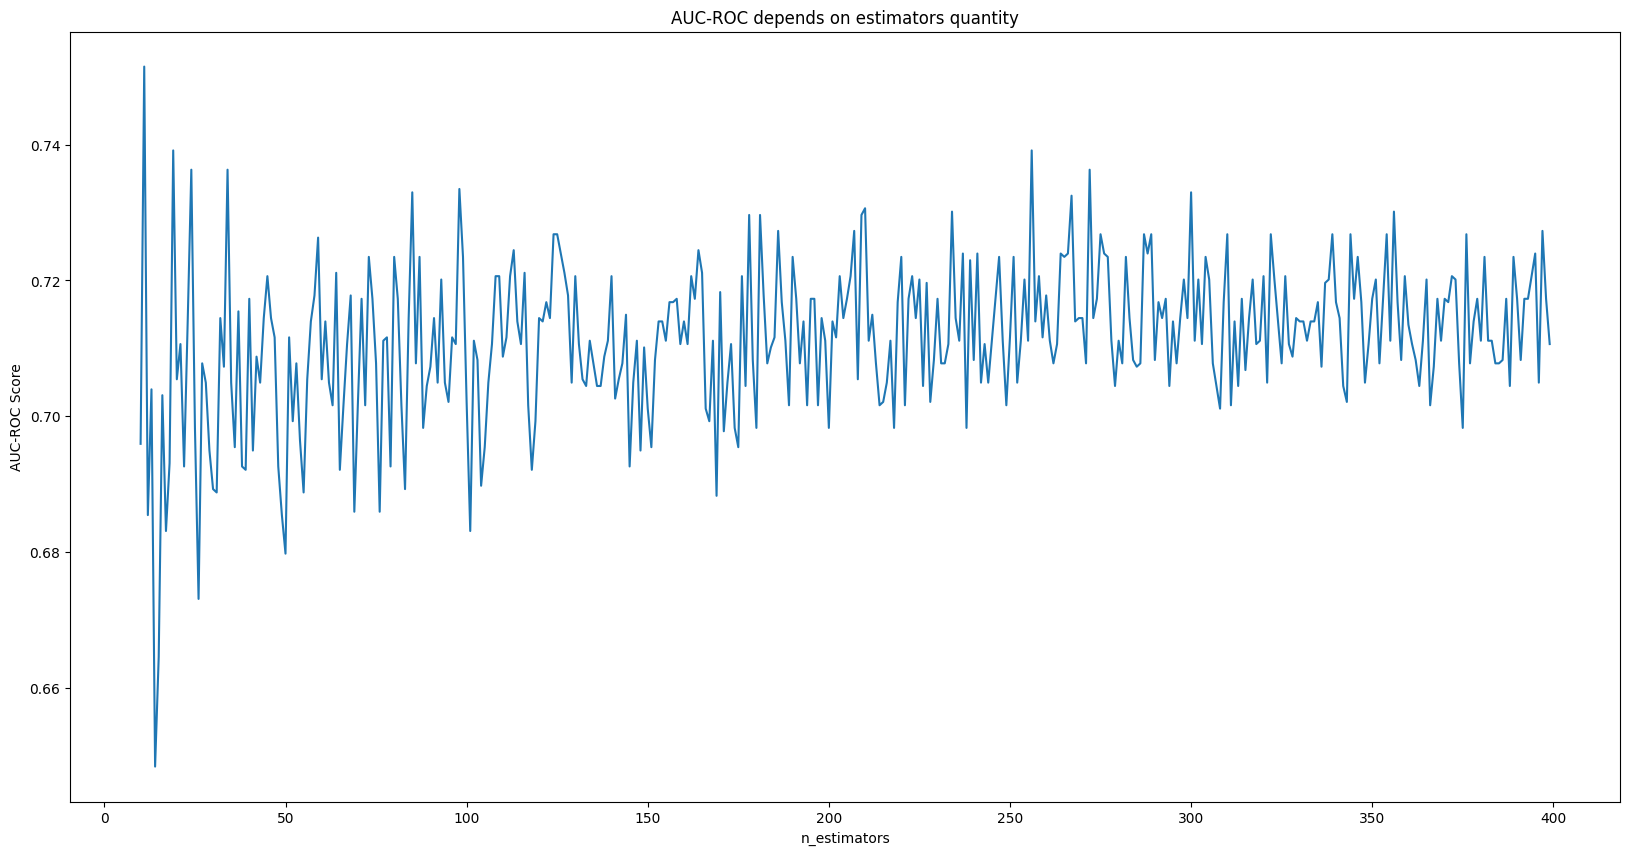

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(range(10, 400), y_axis)
ax.set_title('AUC-ROC depends on estimators quantity')
ax.set_xlabel('n_estimators')
ax.set_ylabel('AUC-ROC Score')
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [38]:
n = y_axis.index(max(y_axis)) + 10 
print(f'Best N : {n}')

Best N : 11


In [39]:
clf_best = RandomForestClassifier(n_estimators=n, max_depth=10, min_samples_leaf=1)
clf_best.fit(X_train, y_train)
f_importances = clf.feature_importances_

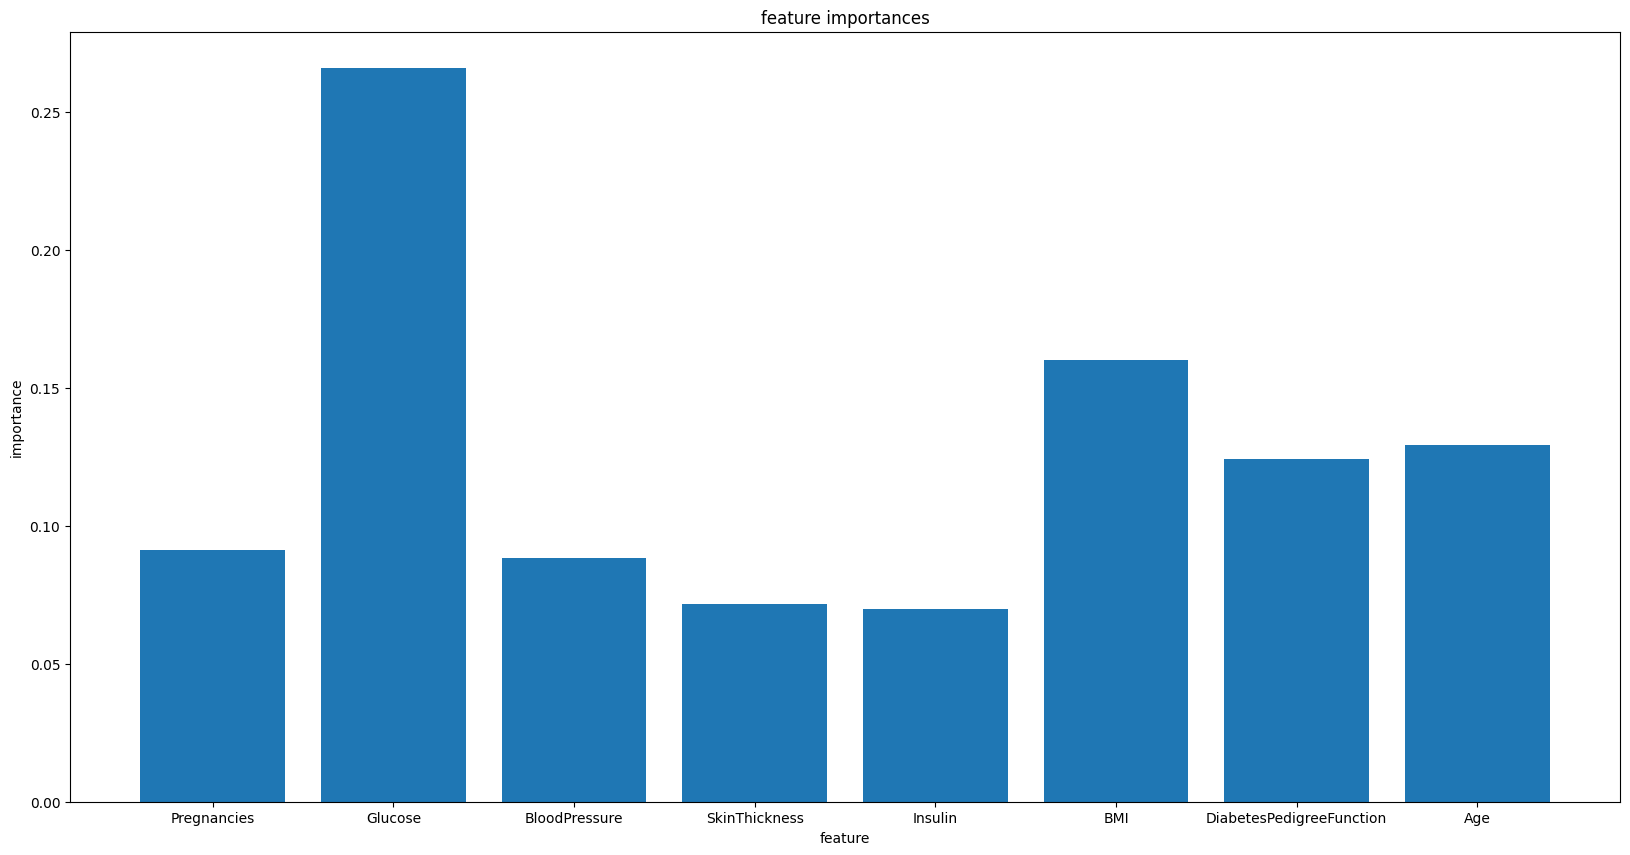

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(X.columns, f_importances)
ax.set_title('feature importances')
ax.set_xlabel('feature')
ax.set_ylabel('importance')
plt.show()